<a href="https://colab.research.google.com/github/ShabnaIlmi/Data-Science-Group-Project/blob/End_User_Risk_Prediction/DSGP_UserData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
from IPython import get_ipython
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from matplotlib.ticker import LogLocator, FuncFormatter
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from datetime import datetime, timedelta
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [ ]:
# Mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Loading the dataset with the proper delimiter (semicolon)
data = pd.read_excel('/content/drive/MyDrive/DSGP_User/Pre Processed data/Stock-report_generated.xlsx', sheet_name='TCC')

# Displaying the first few rows of the data
data.head()


,Warehouse,Product code,Invoice No,Transaction Date,UOM,Issued Qty,Customer name
0,B4,H2O2-50%-IG-TCC-BANGLADESH,SI-N/10/24/197,2024-10-11,KG,150.0,PETTAH CHEMICAL
1,B4,H2O2-50%-IG-TCC-BANGLADESH,SI-N/10/24/205,2024-10-11,KG,30.0,PIYARA WASHING ENTERPRISES
2,B4,H2O2-50%-IG-TCC-BANGLADESH,SI-N/10/24/217,2024-10-12,KG,180.0,RIVINTA DRY AND WASHING
3,B4,H2O2-50%-IG-TCC-BANGLADESH,SI-N/10/24/240,2024-10-15,KG,60.0,SN PRODUCTS
4,B4,H2O2-50%-IG-TCC-BANGLADESH,SI-N/10/24/248,2024-10-15,KG,150.0,NEW BRILLIANT WASHING


In [ ]:
# Displaying information
print("Displaying data information")
data.info()

Displaying data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1631 entries, 0 to 1630
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Warehouse         1587 non-null   object        
 1   Product code      1587 non-null   object        
 2   Invoice No        1587 non-null   object        
 3   Transaction Date  1587 non-null   datetime64[ns]
 4   UOM               1587 non-null   object        
 5   Issued Qty        1587 non-null   float64       
 6   Customer name     1587 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 89.3+ KB


In [ ]:
# Identifying categorical and numerical columns
categorical_cols = data.select_dtypes(include=['object']).columns
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns

# Displaying the categorical features
print("Categorical Features:")
print(categorical_cols)


Categorical Features:
Index(['Warehouse', 'Product code', 'Invoice No', 'UOM', 'Customer name'], dtype='object')


In [ ]:
# Displaying the unique values and their counts relevant to each categorical column
for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(data[col].value_counts(), "\n")


Column: Warehouse
Warehouse
B4       836
WH-75    751
Name: count, dtype: int64 


Column: Product code
Product code
H2O2-50%-IG-TCC-BANGLADESH    427
H2O2-50%-IG-ICL-BANGLADESH    388
LC-IG-PCIPL-INDIA             387
LC-IG-ISGEC-INDIA             385
Name: count, dtype: int64 


Column: Invoice No
Invoice No
SI-N/10/25/474    5
SI-N/11/25/247    5
SI-N/11/25/923    5
SI-N/10/25/905    4
SI-N/11/25/855    4
                 ..
SI-N/11/25/528    1
SI-N/11/25/466    1
SI-N/10/25/163    1
SI-N/10/25/443    1
SI-N/11/25/808    1
Name: count, Length: 1092, dtype: int64 


Column: UOM
UOM
KG    1587
Name: count, dtype: int64 


Column: Customer name
Customer name
SN PRODUCTS             49
Laugfs Holdings         45
Sanitech Chemicals      44
Galagedara CHEMICAL     43
Hirdaramani Group       41
                        ..
SACHITH  FARM            1
LITEOL DETERGENT         1
DAYANI WEAVING MILLS     1
MALEESHA INDUSTRIES      1
GLOW KEM LANKA           1
Name: count, Length: 79, dtype: int

In [ ]:
# Displaying the numerical features
print("Numerical Features:")
print(numerical_cols)

Numerical Features:
Index(['Issued Qty '], dtype='object')


In [ ]:
# Unique values and their counts relevant to each numerical columns
for col in numerical_cols:
    print(f"\nColumn: {col}")
    print(data[col].value_counts(), "\n")


Column: Issued Qty 
Issued Qty 
900.0     29
1800.0    11
60.0       7
90.0       7
300.0      6
          ..
1405.0     1
1298.0     1
1743.0     1
213.0      1
1594.0     1
Name: count, Length: 1203, dtype: int64 



In [ ]:
# Fill missing values in 'Issued Qty' with 0
data['Issued Qty '] = data['Issued Qty '].fillna(0)

In [ ]:
# Strip any leading or trailing spaces from column names
data.columns = data.columns.str.strip()

# Convert 'Transaction Date' to datetime if not already done
data['Transaction Date'] = pd.to_datetime(data['Transaction Date'], errors='coerce')

# 3. Define Thresholds (Adjust these based on your domain knowledge!)
HIGH_USAGE_THRESHOLD = 2000  # Example: Over 2000 units issued in a single transaction is high
FREQUENT_PURCHASE_DAYS = 30    # Example: Purchases within 30 days are considered frequent. (CHANGED)
QUANTITY_DEVIATION_THRESHOLD = 2.0 # Example: Customer issuing/receiving more than double the mean is high

# 4. Calculate Customer Usage Statistics
# Use the stripped column name 'Issued Qty'
customer_mean_usage = data.groupby('Customer name')['Issued Qty'].mean()
customer_std_usage = data.groupby('Customer name')['Issued Qty'].std()

# Function to calculate days since last transaction for a customer
def days_since_last_transaction(data, customer_name, current_date):
    customer_transactions = data[data['Customer name'] == customer_name]['Transaction Date']
    if not customer_transactions.empty:
        last_transaction_date = customer_transactions.max()
        days_difference = (current_date - last_transaction_date).days
        return days_difference
    else:
        return None

# 5. Identify new customers (Less than 90 days since first transaction)
def is_new_customer(data, customer_name, current_date, threshold_days=90):
    customer_transactions = data[data['Customer name'] == customer_name]['Transaction Date']
    if not customer_transactions.empty:
        first_transaction_date = customer_transactions.min()
        days_since_first = (current_date - first_transaction_date).days
        return days_since_first <= threshold_days
    else:
        return True # Treat as new if no transaction history

#6. Define Risk Levels based on the parameters

def assess_risk(row):
    customer = row['Customer name']
    issued_qty = row['Issued Qty']
    transaction_date = row['Transaction Date']

    # Basic Risk Score (Initialized to 0)
    risk_score = 0

    # High Usage Risk Check
    if issued_qty > HIGH_USAGE_THRESHOLD:
        risk_score += 1

    # Usage Deviation Check
    if customer in customer_mean_usage:
        if issued_qty > customer_mean_usage[customer] * QUANTITY_DEVIATION_THRESHOLD:
            risk_score += 1

    # Recent Transaction Check
    today = pd.Timestamp(datetime.now().date())
    days_since_last = days_since_last_transaction(data, customer, today)
    if days_since_last is not None and days_since_last <= FREQUENT_PURCHASE_DAYS:
        risk_score += 1

    # New Customer Check
    if is_new_customer(data, customer, today):
        risk_score += 1

    # Convert Risk Score to Risk Level (Removing "No Risk")
    if risk_score >= 3:
        return 'High Risk'
    elif risk_score == 2:
        return 'Medium Risk'
    else:
        return 'Low Risk'  # Assign Low Risk even if score is 0 or 1

# Apply the modified risk assessment function
data['Risk Level'] = data.apply(assess_risk, axis=1)


# --- Save the Updated Excel File ---
output_file = '/content/drive/MyDrive/DSGP_User/Pre Processed data/Stock-report_with_risk.xlsx'
data.to_excel(output_file, sheet_name='TCC', index=False)
print(f"Updated data saved to '{output_file}'")

# --- Display Risk Level Counts ---
print("\n--- Risk Level Counts ---")
print(data['Risk Level'].value_counts())

Updated data saved to '/content/drive/MyDrive/DSGP_User/Pre Processed data/Stock-report_with_risk.xlsx'

--- Risk Level Counts ---
Risk Level
Low Risk       1274
Medium Risk     321
High Risk        36
Name: count, dtype: int64


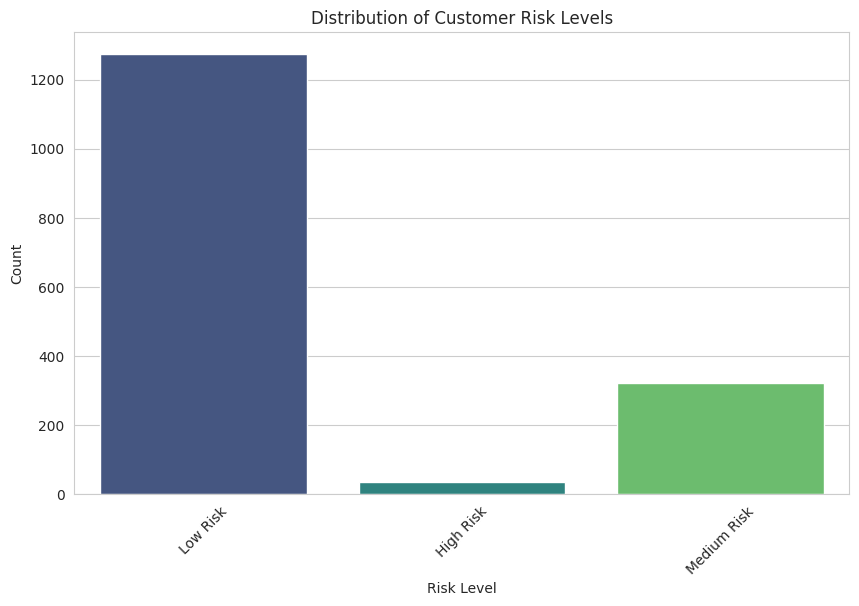

In [ ]:
# Visualizing the distribution of the target variable 'Risk Level'
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Risk Level', palette='viridis')
plt.title('Distribution of Customer Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

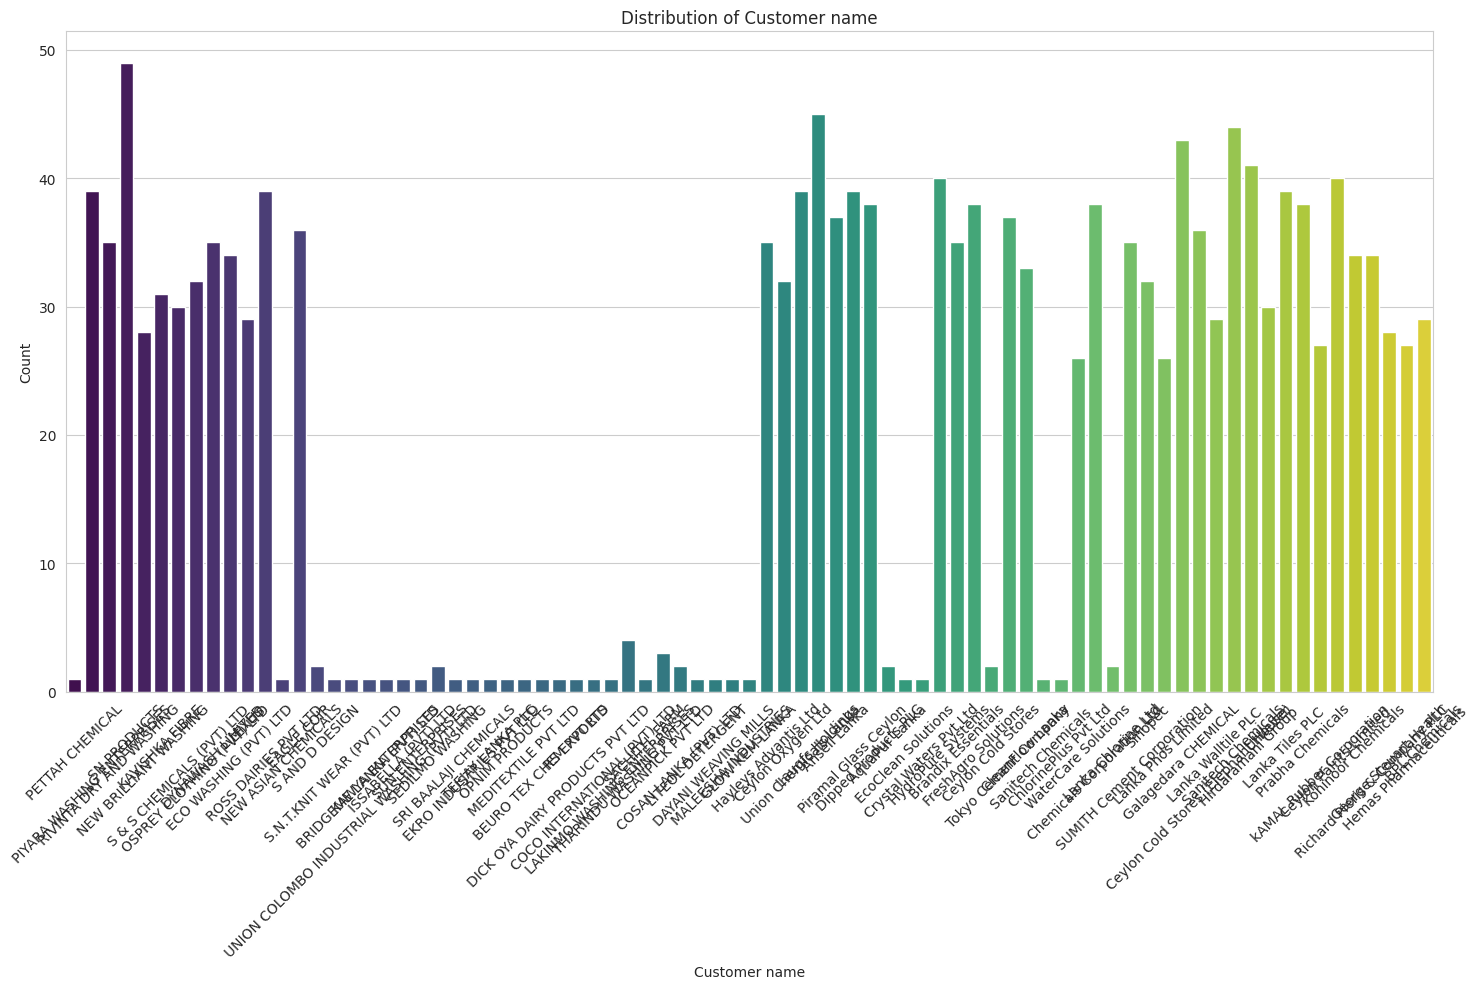

In [ ]:
# Defining a list to store the categorical variables
categorical_columns = [ 'Customer name']

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Loop through each categorical column and create a bar plot
for i, column in enumerate(categorical_columns):
    plt.subplot(len(categorical_columns), 1, i + 1)  # Create a subplot for each column
    sns.countplot(data=data, x=column, palette='viridis')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Rotate x labels for better readability

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


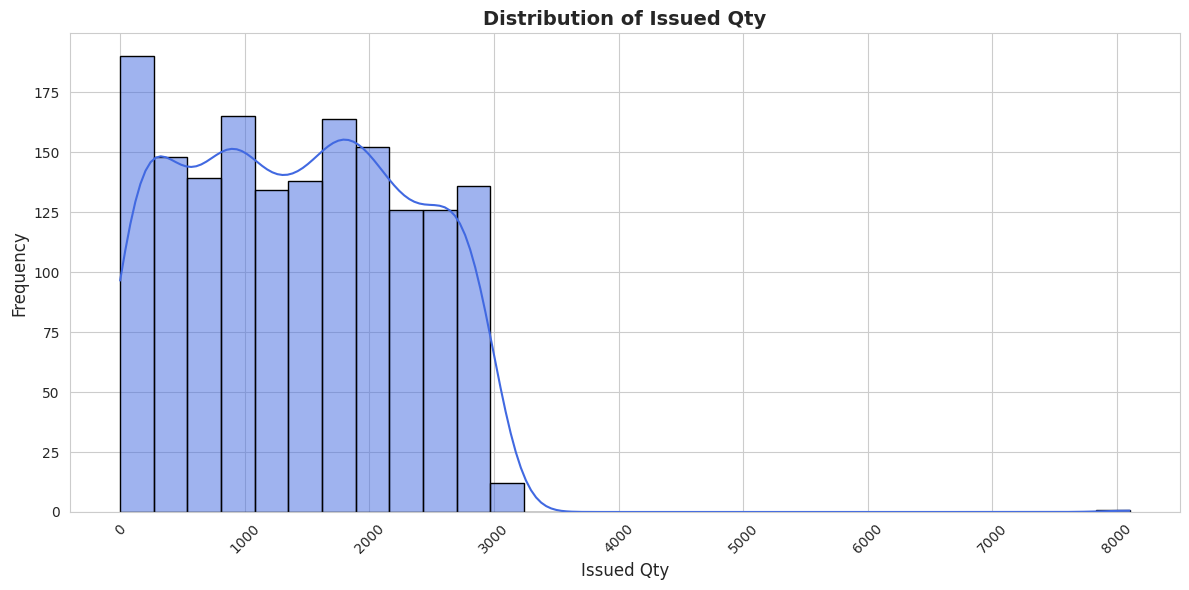

In [ ]:
# Defining a list to store the numerical variables
numerical_columns = ['Issued Qty']  # Ensure correct column name

# Set plot style
sns.set_style("whitegrid")

# Set up the matplotlib figure
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability

# Loop through each numerical column and create a bar plot
for i, column in enumerate(numerical_columns):
    plt.subplot(len(numerical_columns), 1, i + 1)  # Create a subplot for each column

    # Use histogram instead of countplot for numerical data
    sns.histplot(data[column], bins=30, kde=True, color="royalblue", edgecolor="black")

    plt.title(f'Distribution of {column}', fontsize=14, fontweight='bold')
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)  # Rotate x labels for better readability
    plt.yticks(fontsize=10)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
# Strip any leading or trailing spaces from column names
data.columns = data.columns.str.strip()

# Select numerical columns for outlier detection
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Function to detect outliers using the IQR method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Check for outliers in each numerical column
outlier_summary = {}
for col in numerical_columns:
    outliers = detect_outliers_iqr(data, col)
    outlier_summary[col] = len(outliers)

# Display the number of outliers for each numerical column
outlier_summary_df = pd.DataFrame(outlier_summary.items(), columns=['Column', 'Number of Outliers'])
print(outlier_summary_df)

       Column  Number of Outliers
0  Issued Qty                   1


#**Data Preprocessing**

---



In [ ]:
# Step 1: Removing whitespaces from the object type columns
object_columns = data.select_dtypes(include=['object']).columns
data[object_columns] = data[object_columns].apply(lambda x: x.str.strip())

# Step 2: Identifying and displaying duplicate values
print(f"Initial dataset shape: {data.shape}")

# Identify duplicates
duplicates = data[data.duplicated(keep=False)]  # Keep all duplicates for display
print(f"Number of duplicate rows found: {duplicates.shape[0]}")

# Remove duplicate values
data = data.drop_duplicates()
print(f"Shape after removing duplicates: {data.shape}")

Initial dataset shape: (1631, 8)
Number of duplicate rows found: 44
Shape after removing duplicates: (1588, 8)


In [ ]:
# Step 3: Handling missing values in the Categorical Columns

# Checking for missing values in the Categorical Columns
for column in categorical_cols:
    print(f"Missing values for column {column}: {data[column].isnull().sum()}")

Missing values for column Warehouse: 1
Missing values for column Product code: 1
Missing values for column Invoice No: 1
Missing values for column UOM: 1
Missing values for column Customer name: 1


In [ ]:
# Step 4: Handling missing values in the Numerical Columns

# Redefine numerical_cols after stripping column names (or after any operation that modifies column names)
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Checking for missing values in the Numerical Columns
for column in numerical_cols:
    print(f"Missing values for column {column}: {data[column].isnull().sum()}")

Missing values for column Issued Qty: 0


In [ ]:
# Select numerical columns for outlier detection
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Function to cap outliers using the IQR method
def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap the outliers
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

# Apply capping for outliers in each numerical column
for col in numerical_columns:
    data = cap_outliers_iqr(data, col)

# Display the updated DataFrame with capped outliers
print(data[numerical_columns].describe())

        Issued Qty
count  1588.000000
mean   1467.757242
std     857.582177
min       0.000000
25%     743.500000
50%    1462.500000
75%    2171.500000
max    4313.500000


In [ ]:
# All categorical columns are encoded using the label encoding since the categorical data contained within the dataset are ordinal

# Step 5: Encoding the categorical columns

# Defining the columns to be encoded
encoding_cols = ['Warehouse', 'Product code', 'Invoice No', 'UOM', 'Customer name', 'Risk Level']

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to each categorical column
for column in encoding_cols:
    data[column] = label_encoder.fit_transform(data[column])  # Convert to string to handle NaN values

# Display the first few rows of the updated DataFrame
data.head()

,Warehouse,Product code,Invoice No,Transaction Date,UOM,Issued Qty,Customer name,Risk Level
0,0,1,36,2024-10-11,0,150.0,51,1
1,0,1,37,2024-10-11,0,30.0,52,1
2,0,1,38,2024-10-12,0,180.0,55,1
3,0,1,39,2024-10-15,0,60.0,64,1
4,0,1,41,2024-10-15,0,150.0,47,1


In [ ]:
# Redefine numerical_cols after dropping 'Received Qty'
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Step 5: Scaling the Numerical Features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[numerical_cols])

# Step 6: Handling the columns with low correlation coefficients with the target column
correlation_with_target = data.corr()['Risk Level'].sort_values(ascending=False)

# Print the correlation values
print("Correlation with Risk Level:")
print(correlation_with_target)

Correlation with Risk Level:
Risk Level          1.000000
Issued Qty          0.458614
Customer name       0.087517
Invoice No          0.055945
Product code        0.042817
Warehouse           0.033991
Transaction Date    0.011039
UOM                -0.010265
Name: Risk Level, dtype: float64


In [ ]:
# Dropping the columns with low correlation
#columns_to_drop = ['UOM', 'Product code', 'Warehouse', 'Invoice No']
#data = data.drop(columns=columns_to_drop)

columns_to_drop = ['UOM']
data = data.drop(columns=columns_to_drop)


In [ ]:
#def handle_customer_names(data, customer_threshold=5, new_category_name = "Other"):
        # 3. Transform 'Customer name' (group less frequent customers)
    #if 'Customer name' in data.columns: #Check if column exists
        #customer_counts = data['Customer name'].value_counts()
        #infrequent_customers = customer_counts[customer_counts < customer_threshold].index
        #data['Customer name'] = data['Customer name'].replace(infrequent_customers, new_category_name)
    #else:
        #print("Warning: 'Customer name' column not found.")
    #return data



In [ ]:
# Dataset Information
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1588 entries, 0 to 1630
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Warehouse         1588 non-null   int64         
 1   Product code      1588 non-null   int64         
 2   Invoice No        1588 non-null   int64         
 3   Transaction Date  1587 non-null   datetime64[ns]
 4   Issued Qty        1588 non-null   float64       
 5   Customer name     1588 non-null   int64         
 6   Risk Level        1588 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 99.2 KB


In [ ]:
# Step 7: Splitting Features and the Target Variable
X = data.drop(columns=['Risk Level'])
y = data['Risk Level']

# Step 8: Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Analyzing the distribution of the y train dataset
y_train.value_counts(normalize=True)

,proportion
Risk Level,
1,0.771654
2,0.205512
0,0.022835


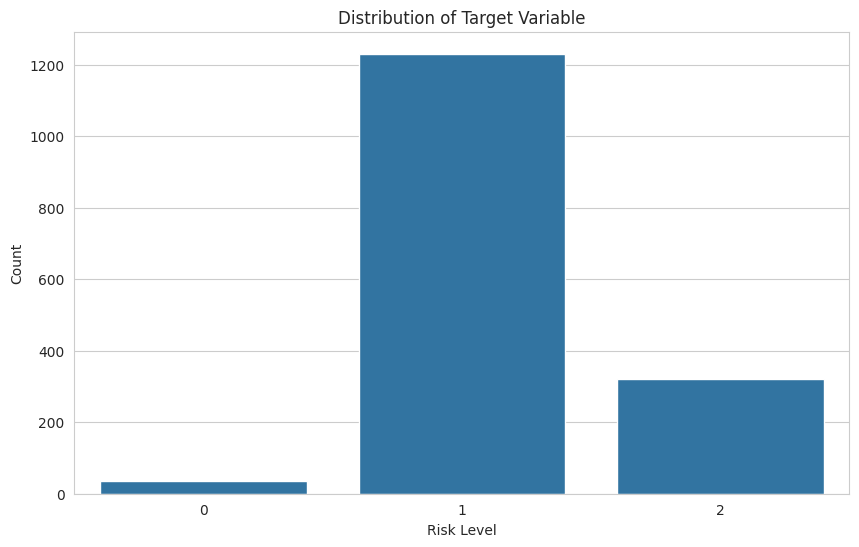

In [ ]:
# Visualizing the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Risk Level')
plt.xticks(rotation=0)
plt.title('Distribution of Target Variable')
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.show()

In [ ]:
# Displaying the dataset shape
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (1270, 6)
Shape of X_test: (318, 6)
Shape of y_train: (1270,)
Shape of y_test: (318,)


In [ ]:
# Step 1: Check for class imbalance in the 'Risk Level' column
class_distribution = data['Risk Level'].value_counts()

# Print the distribution of classes
print("Class distribution in 'Risk Level':")
print(class_distribution)


Class distribution in 'Risk Level':
Risk Level
1    1231
2     321
0      36
Name: count, dtype: int64


Original dataset size: (1588, 6)
Resampled dataset size: (3693, 6)


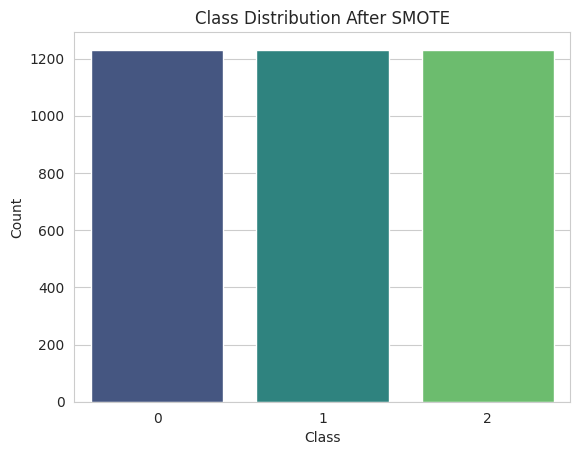

In [ ]:
# Suppressing the FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Handling imbalanced dataset
# --- Convert 'Transaction Date' to numerical representation ---
# Option 1: Days since a reference date
# reference_date = X['Transaction Date'].min()
# X['Transaction Date'] = (X['Transaction Date'] - reference_date).dt.days

# Option 2: Ordinal encoding (if date order is important)
from sklearn.preprocessing import OrdinalEncoder

# Handle NaT values before fitting OrdinalEncoder
X['Transaction Date'] = pd.to_datetime(X['Transaction Date'], errors='coerce')  # Convert to datetime, NaT for errors
X['Transaction Date'] = X['Transaction Date'].fillna(X['Transaction Date'].min()) #Fill NaT with minimum date

encoder = OrdinalEncoder()
X['Transaction Date'] = encoder.fit_transform(X[['Transaction Date']])

# --- Apply SMOTE ---
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Original dataset size:", X.shape)
print("Resampled dataset size:", X_resampled.shape)

# Plotting class distribution after SMOTE
sns.countplot(x=y_resampled, palette="viridis")
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [ ]:
# Define the new folder path
folder_path = '/content/drive/MyDrive/DSGP_User/Pre Processed data'

# Define the file name for the saved dataset
file_name = 'preprocessed_stock_report 1.xlsx'

# Save the pre-processed DataFrame to the new folder
data.to_excel(os.path.join(folder_path, file_name), index=False)

print(f"Pre-processed dataset saved to: {os.path.join(folder_path, file_name)}")

Pre-processed dataset saved to: /content/drive/MyDrive/DSGP_User/Pre Processed data/preprocessed_stock_report 1.xlsx
